<a href="https://colab.research.google.com/github/DayaRodriguezM/ab-testing-landing-page-conversion/blob/main/Proyecto_Landing_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimento A/B en página de inicio

El objetivo de este proyecto es evaluar un **experimento A/B** realizado en una página de inicio (landing page) con versiónes **A y B** para apoyar una **decisión de negocio basada en datos**.

---

El archivo `landing_experiment.csv` contiene información de usuarios expuestos a dos versiones de la página de inicio (landing page) dentro del experimento A/B. Incluye región, dispositivo, fuente de tráfico, tipo de usuario, conversión y gasto.

El análisis sigue una lógica clara y progresiva:

1. 🔍 Explorar y validar los datos.

2. 💰 Comparar el **gasto promedio** por usuario entre la página A y B.

3. 🎯 Comparar la **tasa de conversión** entre la página A y B.

4. 🌐 Revisar **la relación entre la fuente de tráfico y la conversión**.

5. 👤 Revisar **la relación entre el tipo de usuario y la conversión**.

6. 📈 **Visualizar los resultados**: Respalda tus conclusiones mediante gráficos claros.

Se aplican **puebas estadísticas apropiados** para comparar las páginas y **recomendar qué versión es mejor**, justificando la decisión con datos.

## 🧩 Paso 1: Cargar y validar los datos

### 1.1 Carga de datos y vista rápida

In [ ]:
# importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
# cargar archivo
# Carga del dataset original
df_raw = pd.read_csv('/datasets/landing_experiment.csv')

# Copia de trabajo
df = df_raw.copy()

**Vista previa e información general del conjunto de datos**

In [ ]:
# mostrar las primeras 5 filas
df.head(5)

,user_id,date,landing,region,dispositivo,traffic_source,user_type,converted,gasto
0,26f3052e-8500-44ea-8fff-06de65258abb,2026-01-01,A,Norte,Mobile,Email,Recurrente,1,38.08
1,92378c09-4bbf-40c7-945e-82b84f392d22,2026-01-23,A,Occidente,Mobile,Organic,Nuevo,0,0.00
2,a4397360-40e5-45d6-a7ff-dcb4da2c9a1f,2026-01-01,B,Centro,Mobile,Organic,Nuevo,0,0.00
3,7ca3a26f-1e6c-44aa-9b09-b8cb01112956,2026-01-22,A,Centro,Mobile,Ads,Nuevo,0,0.00
4,8dc9593b-5b9c-479d-848b-a99493920419,2026-01-16,A,Sur,Mobile,Organic,Nuevo,0,0.00


In [ ]:
# información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         40000 non-null  object 
 1   date            40000 non-null  object 
 2   landing         40000 non-null  object 
 3   region          40000 non-null  object 
 4   dispositivo     40000 non-null  object 
 5   traffic_source  40000 non-null  object 
 6   user_type       40000 non-null  object 
 7   converted       40000 non-null  int64  
 8   gasto           40000 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 2.7+ MB


✍️ **Comentario**:

En la primera revisión del conjunto de datos se observa que todas las columnas presentan valores completos, sin registros nulos, lo que indica una buena calidad inicial de la información.

No obstante, la columna `date` se encuentra almacenada como tipo `object`, cuando conceptualmente representa una variable temporal. Será necesario convertirla a tipo datetime para permitir análisis temporales y garantizar un tratamiento adecuado en las siguientes etapas del análisis.

**Descripción del conjunto de datos**

El dataset contiene las siguientes columnas:

- `user_id` — Identificador único del usuario
- `date` — Fecha en la que el usuario fue expuesto a la página
- `landing` — Versión de la página mostrada al usuario
- `region` — Región geográfica del usuario
- `dispositivo` — Tipo de dispositivo utilizado por el usuario
- `traffic_source` — Canal por el que llegó el usuario
- `user_type` — Tipo de usuario según historial previo
- `converted` — Indica si el usuario realizó una conversión
- `gasto` — Monto gastado por el usuario (0 si no convirtió)

### 1.2 Análisis exploratorio y revisión de calidad de datos

Se identifican las variables clave del experimento A/B y se valida que estén bien definidas, completas y que sean consistentes.


 **Variable `user_id`**  
 Verificar usuarios únicos

In [ ]:
df['user_id'].nunique()

40000

 **Variable `date`**  
Explorar rango de fechas

In [ ]:
# Resumen estadístico
df["date"].describe()

count          40000
unique            28
top       2026-01-24
freq            1512
Name: date, dtype: object

In [ ]:
# Identificar rango temporal del experimento
print("Fecha mínima:", df["date"].min())
print("Fecha máxima:", df["date"].max())

Fecha mínima: 2026-01-01
Fecha máxima: 2026-01-28


In [ ]:
# Convertir tipo de dato
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print(df['date'].dtype)
print(df['date'].describe())

datetime64[ns]
count                   40000
unique                     28
top       2026-01-24 00:00:00
freq                     1512
first     2026-01-01 00:00:00
last      2026-01-28 00:00:00
Name: date, dtype: object


**Variable `gasto` (numérica)**

In [ ]:
# Resumen estadístico
df["gasto"].describe()

count    40000.000000
mean         9.325554
std         25.667986
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        303.680000
Name: gasto, dtype: float64

In [ ]:
# ¿Cuántos usuarios tienen gasto = 0?
print(f"Usuarios con gasto = 0: {(df['gasto'] == 0).sum()}")
print(f"Usuarios con gasto > 0: {(df['gasto'] > 0).sum()}")

Usuarios con gasto = 0: 34294
Usuarios con gasto > 0: 5706


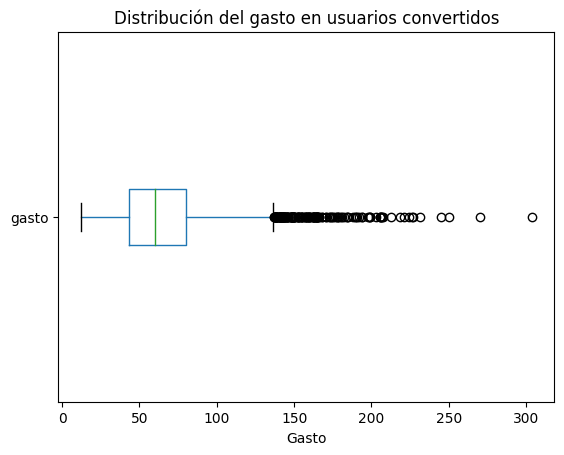

In [ ]:
df[df['converted'] == 1]['gasto'].plot(kind='box', vert=False)
plt.title('Distribución del gasto en usuarios convertidos')
plt.xlabel('Gasto')
plt.show()

In [ ]:
# Resumen estadístico de usuarios que se convirtieron
df["converted"].describe()

count    40000.00000
mean         0.14265
std          0.34972
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          1.00000
Name: converted, dtype: float64

 **Variables categóricas**  
 Verificar categorías esperadas del experimento ( A y B).

In [ ]:
# Explorar variables categóricas y cómo se distribuyen

print("\nConteo de categorías:")
for col in ['landing', 'region', 'dispositivo', 'traffic_source', 'user_type']:
    print(f"\n{col}:")
    print(df[col].value_counts())


Conteo de categorías:

landing:
B    20018
A    19982
Name: landing, dtype: int64

region:
Norte        11166
Centro        9613
Sur           8039
Occidente     6398
Oriente       4784
Name: region, dtype: int64

dispositivo:
Mobile     24829
Desktop    15171
Name: dispositivo, dtype: int64

traffic_source:
Organic     17987
Ads         11935
Email        6123
Referral     3955
Name: traffic_source, dtype: int64

user_type:
Nuevo         26033
Recurrente    13967
Name: user_type, dtype: int64


✍️ **Comentario**:

Durante la exploración inicial del conjunto de datos se revisaron las variables temporales, numéricas y categóricas con el objetivo de validar su calidad, consistencia y adecuación para el análisis del experimento A/B.

**Variable date:**
La variable `date` se encuentra correctamente convertida al tipo datetime, no presenta valores nulos ni fechas improbables. El rango temporal observado es coherente y acotado, lo que indica que el periodo del experimento es válido y no introduce sesgos temporales evidentes para el análisis.

**Variable numérica gasto:**
La variable `gasto` no presenta valores nulos. El análisis visual mediante boxplot revela una distribución fuertemente sesgada a la derecha, con una larga cola de valores altos.
La mayor parte de los valores se concentra cerca de cero, con una mediana muy próxima al primer cuartil, mientras que los valores atípicos se extienden hacia la derecha, lo que explica la alta dispersión observada. Este comportamiento es consistente con patrones típicos de ecommerce, donde un número reducido de usuarios realiza compras de mayor valor.

**Variable converted:**
La variable `converted` presenta una distribución binaria esperada en un experimento de conversión, con una proporción mayoritaria de usuarios que no convierten y una fracción menor que completa la compra. Esta estructura es consistente con un escenario real de embudo de conversión y permite su uso como variable objetivo del experimento A/B.

**Variables categóricas:**
Las variables categóricas exploradas (`landing`, `region`,`dispositivo`, `traffic_source` y `user_type`) presentan valores completos y una distribución coherente con el contexto del negocio. En particular, la variable landing muestra un balance adecuado entre las versiones A y B, condición necesaria para la validez del experimento A/B. Las restantes variables exhiben tamaños de muestra suficientes en cada categoría para realizar análisis segmentados posteriores.

## 💰 Paso 2: Comparar el gasto promedio por usuario (página A vs B)

Se evalua si existen diferencias estadísticamente significativas en el gasto promedio de los **usuarios que se convirtieron en clientes** entre la página A y la página B, para identificar qué versión genera **mayor valor económico** para el negocio.


In [ ]:
# Gasto por versión
gasto_A = df[(df['landing'] == 'A') & (df['converted'] == 1)]['gasto']
gasto_B = df[(df['landing'] == 'B') & (df['converted'] == 1)]['gasto']

# Verificar cantidad de datos que tiene cada grupo
len(gasto_A), len(gasto_B)

(2512, 3194)

In [ ]:
# Estadísticas descriptivas de ambos grupos
print("=== Estadísticas descriptivas ===")
print(f"\nPágina A - Gasto promedio: ${gasto_A.mean():.2f} | Mediana: ${gasto_A.median():.2f} | Desv. estándar: ${gasto_A.std():.2f}")
print(f"Página B - Gasto promedio: ${gasto_B.mean():.2f} | Mediana: ${gasto_B.median():.2f} | Desv. estándar: ${gasto_B.std():.2f}")

=== Estadísticas descriptivas ===

Página A - Gasto promedio: $61.09 | Mediana: $55.84 | Desv. estándar: $28.88
Página B - Gasto promedio: $68.75 | Mediana: $62.57 | Desv. estándar: $32.00


### Prueba de hipótesis (Mann-Whitney U)

**Hipótesis:**
- **Hipótesis nula (H₀):** No existe diferencia significativa en el gasto promedio entre los usuarios convertidos de la página A y la página B.
- **Hipótesis alternativa (H₁):** Existe una diferencia significativa en el gasto promedio entre los usuarios convertidos de la página A y la página B.

In [ ]:
# Verificar normalidad (Shapiro-Wilk sobre una muestra para eficiencia)
muestra_A = gasto_A.sample(min(5000, len(gasto_A)), random_state=42)
muestra_B = gasto_B.sample(min(5000, len(gasto_B)), random_state=42)

stat_A, p_norm_A = stats.shapiro(muestra_A)
stat_B, p_norm_B = stats.shapiro(muestra_B)

print("=== Prueba de normalidad (Shapiro-Wilk) ===")
print(f"Página A → Estadístico: {stat_A:.4f} | Valor p: {p_norm_A:.4f}")
print(f"Página B → Estadístico: {stat_B:.4f} | Valor p: {p_norm_B:.4f}")

print("\n=== Decisión metodológica ===")

if p_norm_A < 0.05 or p_norm_B < 0.05:
    print(
        "Se observa evidencia de desviación de la normalidad en al menos uno de los grupos.\n"
        "Considerando además la asimetría y la presencia de valores extremos en la distribución del gasto,\n"
        "se opta por aplicar la prueba no paramétrica de Mann-Whitney U para una inferencia más robusta.\n"
    )
else:
    print(
        "No se detectan desviaciones significativas de la normalidad.\n"
        "Podría considerarse la aplicación de una prueba t para la comparación de medias.\n"
    )

=== Prueba de normalidad (Shapiro-Wilk) ===
Página A → Estadístico: 0.8948 | Valor p: 0.0000
Página B → Estadístico: 0.9271 | Valor p: 0.0000

=== Decisión metodológica ===
Se observa evidencia de desviación de la normalidad en al menos uno de los grupos.
Considerando además la asimetría y la presencia de valores extremos en la distribución del gasto,
se opta por aplicar la prueba no paramétrica de Mann-Whitney U para una inferencia más robusta.



In [ ]:
# Aplicar prueba Mann-Whitney U (no paramétrica, robusta para distribuciones sesgadas)
stat_mw, p_valor = stats.mannwhitneyu(
    gasto_A, gasto_B, alternative='two-sided'
)

print("=== Prueba Mann-Whitney U ===")
print(f"Tamaño muestra A: {len(gasto_A)}")
print(f"Tamaño muestra B: {len(gasto_B)}")
print(f"Estadístico U   : {stat_mw:.4f}")
print(f"Valor p         : {p_valor:.4f}\n")

print("=== Estadísticos relevantes ===")
print(f"Mediana A: ${gasto_A.median():.2f}")
print(f"Mediana B: ${gasto_B.median():.2f}")

# Tamaño del efecto
rbc = 1 - (2 * stat_mw) / (len(gasto_A) * len(gasto_B))
print(f"Tamaño del efecto (Rank-Biserial): {rbc:.4f}")

=== Prueba Mann-Whitney U ===
Tamaño muestra A: 2512
Tamaño muestra B: 3194
Estadístico U   : 3420354.0000
Valor p         : 0.0000

=== Estadísticos relevantes ===
Mediana A: $55.84
Mediana B: $62.57
Tamaño del efecto (Rank-Biserial): 0.1474


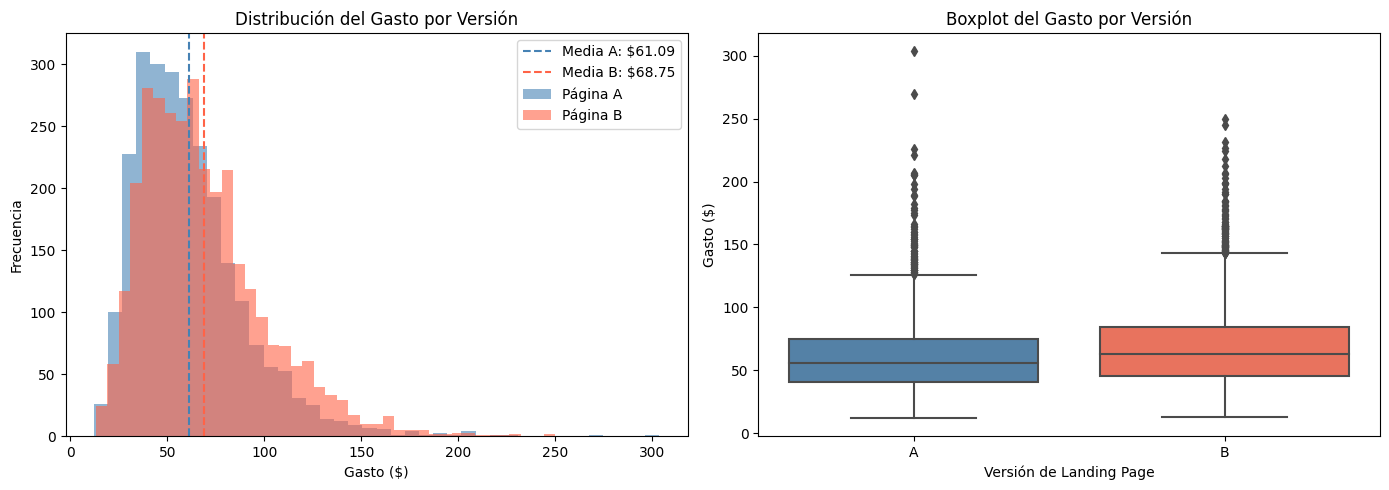

In [ ]:
# Visualización: distribución del gasto por versión
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(gasto_A, bins=40, alpha=0.6, color='steelblue', label='Página A')
axes[0].hist(gasto_B, bins=40, alpha=0.6, color='tomato', label='Página B')
axes[0].axvline(gasto_A.mean(), color='steelblue', linestyle='--', linewidth=1.5, label=f'Media A: ${gasto_A.mean():.2f}')
axes[0].axvline(gasto_B.mean(), color='tomato', linestyle='--', linewidth=1.5, label=f'Media B: ${gasto_B.mean():.2f}')
axes[0].set_title('Distribución del Gasto por Versión')
axes[0].set_xlabel('Gasto ($)')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

# Boxplot
data_box = pd.DataFrame({
    'Gasto': pd.concat([gasto_A, gasto_B], ignore_index=True),
    'Versión': ['A'] * len(gasto_A) + ['B'] * len(gasto_B)
})
sns.boxplot(data=data_box, x='Versión', y='Gasto', palette={'A': 'steelblue', 'B': 'tomato'}, ax=axes[1])
axes[1].set_title('Boxplot del Gasto por Versión')
axes[1].set_xlabel('Versión de Landing Page')
axes[1].set_ylabel('Gasto ($)')

plt.tight_layout()
plt.show()

In [ ]:
alpha = 0.05

print("=== Decisión ===")
if p_valor < alpha:
    decision = "RECHAZA"
    conclusion = (
        f"Con un valor p de {p_valor:.4f} (< {alpha}), se rechaza la hipótesis nula.\n"
        f"Existe evidencia estadísticamente significativa de que la distribución\n"
        f"del gasto de los usuarios convertidos difiere entre la página A y la página B.\n\n"
        f"Desde una perspectiva descriptiva, la página A presenta una media de\n"
        f"${gasto_A.mean():.2f} y una mediana de ${gasto_A.median():.2f}, mientras que\n"
        f"la página B muestra una media de ${gasto_B.mean():.2f} y una mediana de\n"
        f"${gasto_B.median():.2f}."
    )
else:
    decision = "NO SE RECHAZA"
    conclusion = (
        f"Con un valor p de {p_valor:.4f} (>= {alpha}), no se rechaza la hipótesis nula.\n"
        f"No existe evidencia suficiente para afirmar que la distribución del gasto\n"
        f"de los usuarios convertidos difiere significativamente entre la página A y la página B.\n\n"
        f"Las métricas descriptivas muestran una media de ${gasto_A.mean():.2f} para la página A\n"
        f"y de ${gasto_B.mean():.2f} para la página B."
    )

print(f"→ Se {decision} la hipótesis nula H₀.\n")
print("=== Interpretación de negocio ===")
print(conclusion)

diferencia = gasto_B.mean() - gasto_A.mean()
print(f"\nDiferencia en gasto promedio (B - A): ${diferencia:.2f}")

if diferencia > 0:
    print("En términos económicos, la página B genera mayor ingreso promedio por usuario convertido.")
else:
    print("En términos económicos, la página A genera mayor ingreso promedio por usuario convertido.")

=== Decisión ===
→ Se RECHAZA la hipótesis nula H₀.

=== Interpretación de negocio ===
Con un valor p de 0.0000 (< 0.05), se rechaza la hipótesis nula.
Existe evidencia estadísticamente significativa de que la distribución
del gasto de los usuarios convertidos difiere entre la página A y la página B.

Desde una perspectiva descriptiva, la página A presenta una media de
$61.09 y una mediana de $55.84, mientras que
la página B muestra una media de $68.75 y una mediana de
$62.57.

Diferencia en gasto promedio (B - A): $7.66
En términos económicos, la página B genera mayor ingreso promedio por usuario convertido.



### 📝 Conclusión e interpretación

**Decisión estadística:** Se rechaza la hipótesis nula.

**Interpretación estadística:**
Existe evidencia estadísticamente significativa de que la distribución del gasto de los usuarios convertidos difiere entre la página A y la página B (prueba Mann-Whitney U, p < 0.05).

**Interpretación de negocio:**
Como confirman los resultados anteriores, la página B presenta un mayor gasto promedio por usuario convertido (68.75 USD vs 61.09 USD), lo que representa un incremento de 7.66USD por usuario convertido.
Este resultado es consistente visualmente y no está dominado por valores extremos, por lo que se considera una señal robusta para la toma de decisión.




## 📈 Paso 3: Comparar la tasa de conversión entre la página A y B

Se evalua si existen diferencias estadísticamente significativas en la **tasa de conversión** entre la página A y B, con el fin de identificar qué versión genera **mayor número de usuarios convertidos**.

### Prueba Z-test

**Hipótesis:**
- **Hipótesis nula (H₀):** La tasa de conversión es igual para la página A y la página B.
- **Hipótesis alternativa (H₁):** La tasa de conversión difiere entre la página A y la página B.

In [ ]:
# ── Calcular conversiones por grupo ──
conv_A = df[df['landing'] == 'A']['converted']
conv_B = df[df['landing'] == 'B']['converted']

n_A = len(conv_A)           # Total usuarios página A
n_B = len(conv_B)           # Total usuarios página B
conv_A_sum = conv_A.sum()   # Convertidos página A
conv_B_sum = conv_B.sum()   # Convertidos página B

tasa_A = conv_A.mean()      # Tasa de conversión A
tasa_B = conv_B.mean()      # Tasa de conversión B

print("=== Estadísticas de conversión ===")
print(f"Página A → Usuarios: {n_A:,} | Convertidos: {conv_A_sum:,} | Tasa: {tasa_A:.4f} ({tasa_A*100:.2f}%)")
print(f"Página B → Usuarios: {n_B:,} | Convertidos: {conv_B_sum:,} | Tasa: {tasa_B:.4f} ({tasa_B*100:.2f}%)")
print(f"\nDiferencia en tasa (B - A): {(tasa_B - tasa_A)*100:.2f} puntos porcentuales")

=== Estadísticas de conversión ===
Página A → Usuarios: 19,982 | Convertidos: 2,512 | Tasa: 0.1257 (12.57%)
Página B → Usuarios: 20,018 | Convertidos: 3,194 | Tasa: 0.1596 (15.96%)

Diferencia en tasa (B - A): 3.38 puntos porcentuales


In [ ]:
# Aplicar prueba
from statsmodels.stats.proportion import proportions_ztest
alpha = 0.05

# ── Test Z de proporciones ──
count = np.array([conv_A_sum, conv_B_sum])
nobs  = np.array([n_A, n_B])

stat_z, p_valor_z = proportions_ztest(count, nobs, alternative='two-sided')

# ── Chi-cuadrado (verificación cruzada) ──
tabla_contingencia = pd.crosstab(df['landing'], df['converted'])
chi2, p_valor_chi2, dof, expected = stats.chi2_contingency(tabla_contingencia)

print("=== Test Z de Proporciones ===")
print(f"Estadístico Z : {stat_z:.4f}")
print(f"Valor p       : {p_valor_z:.4f}")

print("\n=== Chi-cuadrado de independencia (verificación) ===")
print(f"Estadístico χ²: {chi2:.4f}")
print(f"Valor p        : {p_valor_chi2:.4f}")
print(f"Grados libertad: {dof}")

=== Test Z de Proporciones ===
Estadístico Z : -9.6774
Valor p       : 0.0000

=== Chi-cuadrado de independencia (verificación) ===
Estadístico χ²: 93.3748
Valor p        : 0.0000
Grados libertad: 1


In [ ]:
# ── Effect size: Relative Uplift y Risk Ratio ──
uplift_relativo = (tasa_B - tasa_A) / tasa_A * 100
risk_ratio      = tasa_B / tasa_A

# ── Effect size: Cohen's h (específico para proporciones) ──
cohen_h = 2 * np.arcsin(np.sqrt(tasa_B)) - 2 * np.arcsin(np.sqrt(tasa_A))

print("\n=== Effect Size ===")
print(f"Uplift relativo (B vs A) : {uplift_relativo:+.2f}%")
print(f"Risk Ratio (B/A)         : {risk_ratio:.4f}")
print(f"Cohen's h                : {cohen_h:.4f}  → {'pequeño' if abs(cohen_h) < 0.2 else 'mediano' if abs(cohen_h) < 0.5 else 'grande'}")


=== Effect Size ===
Uplift relativo (B vs A) : +26.92%
Risk Ratio (B/A)         : 1.2692
Cohen's h                : 0.0969  → pequeño


In [ ]:
# ── Intervalo de confianza al 95% para la diferencia de proporciones ──
from statsmodels.stats.proportion import confint_proportions_2indep

ci_low, ci_high = confint_proportions_2indep(
    conv_B_sum, n_B, conv_A_sum, n_A,
    method='wald', alpha=0.05
)

print(f"\nIC 95% para (p_B - p_A): [{ci_low*100:.3f}%, {ci_high*100:.3f}%]")
print("→ Si el intervalo NO incluye 0, la diferencia es significativa.")


IC 95% para (p_B - p_A): [2.700%, 4.069%]
→ Si el intervalo NO incluye 0, la diferencia es significativa.


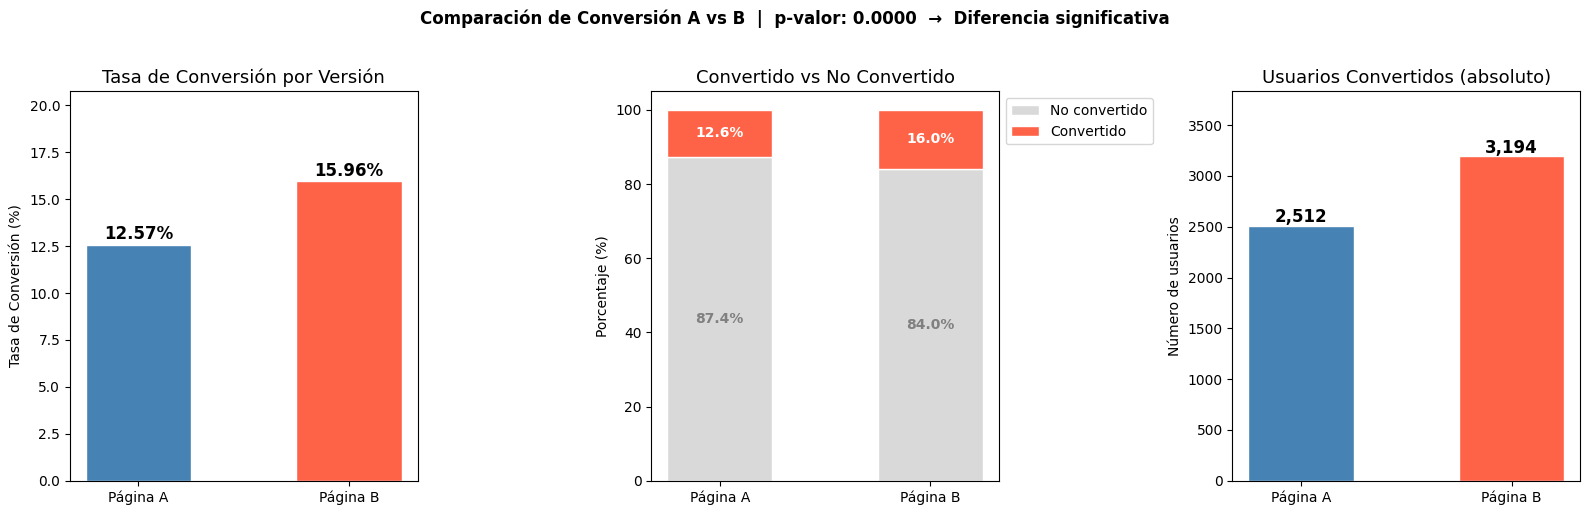

In [ ]:
# Visualización
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

versiones = ['Página A', 'Página B']
tasas     = [tasa_A * 100, tasa_B * 100]
colores   = ['steelblue', 'tomato']

# ── Gráfico 1: Tasa de conversión (%) ──
bars = axes[0].bar(versiones, tasas, color=colores, width=0.5, edgecolor='white')
for bar, t in zip(bars, tasas):
    axes[0].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.3,
                 f'{t:.2f}%', ha='center', fontweight='bold', fontsize=12)
axes[0].set_title('Tasa de Conversión por Versión', fontsize=13)
axes[0].set_ylabel('Tasa de Conversión (%)')
axes[0].set_ylim(0, max(tasas) * 1.3)

# ── Gráfico 2: Stacked bar convertido vs no convertido ──
pct_conv    = np.array([tasa_A * 100, tasa_B * 100])
pct_no_conv = 100 - pct_conv
x = np.arange(2)

axes[1].bar(x, pct_no_conv, 0.5, label='No convertido', color='#d9d9d9', edgecolor='white')
axes[1].bar(x, pct_conv,    0.5, label='Convertido',    color='tomato',  edgecolor='white',
            bottom=pct_no_conv)

for i in range(2):
    axes[1].text(i, pct_no_conv[i] / 2,
                 f'{pct_no_conv[i]:.1f}%', ha='center', va='center',
                 fontsize=10, color='gray', fontweight='bold')
    axes[1].text(i, pct_no_conv[i] + pct_conv[i] / 2,
                 f'{pct_conv[i]:.1f}%', ha='center', va='center',
                 fontsize=10, color='white', fontweight='bold')

axes[1].set_title('Convertido vs No Convertido', fontsize=13)
axes[1].set_ylabel('Porcentaje (%)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(versiones)
axes[1].legend(loc='upper left',bbox_to_anchor=(1,1))

# ── Gráfico 3: Conteo absoluto de convertidos ──
conteos = [conv_A_sum, conv_B_sum]
bars3   = axes[2].bar(versiones, conteos, color=colores, width=0.5, edgecolor='white')
for bar, c in zip(bars3, conteos):
    axes[2].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 30,
                 f'{c:,}', ha='center', fontweight='bold', fontsize=12)
axes[2].set_title('Usuarios Convertidos (absoluto)', fontsize=13)
axes[2].set_ylabel('Número de usuarios')
axes[2].set_ylim(0, max(conteos) * 1.2)

plt.suptitle(f'Comparación de Conversión A vs B  |  p-valor: {p_valor_z:.4f}  →  {"Diferencia significativa" if p_valor_z < alpha else "❌ Sin diferencia significativa"}',
             fontsize=12, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

In [ ]:
print("=== DECISIÓN ===")
if p_valor_z < alpha:
    print(f"→ Se RECHAZA la hipótesis nula H₀ (p = {p_valor_z:.4f} < {alpha})")
    print(f"  Existe diferencia estadísticamente significativa en la tasa de conversión.")
else:
    print(f"→ NO se rechaza la hipótesis nula H₀ (p = {p_valor_z:.4f} ≥ {alpha})")
    print(f"  No hay evidencia suficiente de diferencia en la tasa de conversión.")

print("\n=== INTERPRETACIÓN DE NEGOCIO ===")
print(f"  • Página A convierte el {tasa_A*100:.2f}% de sus usuarios.")
print(f"  • Página B convierte el {tasa_B*100:.2f}% de sus usuarios.")
print(f"  • La página B genera un uplift relativo de {uplift_relativo:+.2f}% sobre A.")
print(f"  • Por cada 1,000 usuarios, B convierte ~{int((tasa_B-tasa_A)*1000)} usuarios adicionales.")
print(f"  • El IC 95% confirma que la diferencia real está entre {ci_low*100:.2f}% y {ci_high*100:.2f}%.")

=== DECISIÓN ===
→ Se RECHAZA la hipótesis nula H₀ (p = 0.0000 < 0.05)
  Existe diferencia estadísticamente significativa en la tasa de conversión.

=== INTERPRETACIÓN DE NEGOCIO ===
  • Página A convierte el 12.57% de sus usuarios.
  • Página B convierte el 15.96% de sus usuarios.
  • La página B genera un uplift relativo de +26.92% sobre A.
  • Por cada 1,000 usuarios, B convierte ~33 usuarios adicionales.
  • El IC 95% confirma que la diferencia real está entre 2.70% y 4.07%.


### 📝 Conclusión e interpretación

**Decisión estadística:** Se rechaza la hipótesis nula.  

**Interpretación estadística:** Existe evidencia estadísticamente significativa de que la tasa de conversión difiere entre la página A y la página B, de acuerdo con el Z-test de proporciones (p < 0.05).
El resultado indica que la proporción de usuarios que convierten no es equivalente entre ambas versiones de la landing page, y que la diferencia observada es altamente improbable que se deba al azar.
Este hallazgo es consistente y respaldado por una prueba Chi-cuadrado de independencia, lo que refuerza la robustez estadística del resultado.


**Interpretación de negocio:** La página A presenta una tasa de conversión del 12.57%, mientras que la página B alcanza una tasa del 15.96%.
Dado que esta diferencia es estadísticamente significativa y cumple con los supuestos del test aplicado, la página B demuestra un mejor desempeño en términos de generación de usuarios convertidos dentro del experimento.

## 🔗 Paso 4: Revisar la relación entre la fuente de tráfico y la conversión

Se analiza si existe una **asociación estadísticamente significativa** entre la **fuente de tráfico** (`traffic_source`) y la **conversión** (`converted`), para identificar qué canales generan más conversiones.

### Prueba Chi-cuadrado de independencia

**Hipótesis:**
- **Hipótesis nula (H₀):** La conversión es independiente de la fuente de tráfico.
- **Hipótesis alternativa (H₁):** Existe asociación entre la fuente de tráfico y la conversión.

In [ ]:
alpha = 0.05

# Tabla de contingencia

tabla_trafico = pd.crosstab(df['traffic_source'], df['converted'])

print("=== Tabla de contingencia ===")
display(tabla_trafico)

=== Tabla de contingencia ===


converted,0,1
traffic_source,,
Ads,10176,1759
Email,5205,918
Organic,15507,2480
Referral,3406,549


In [ ]:
# Aplicar prueba Chi-cuadrado

chi2, p_value, dof, expected = stats.chi2_contingency(tabla_trafico)

print("\n=== Test Chi-cuadrado ===")
print(f"Estadístico χ² : {chi2:.4f}")
print(f"Valor p        : {p_value:.4f}")
print(f"Grados libertad: {dof}")


=== Test Chi-cuadrado ===
Estadístico χ² : 8.6621
Valor p        : 0.0341
Grados libertad: 3


In [ ]:
# Tasa de conversión por canal
conversion_por_canal = (
    df.groupby('traffic_source')['converted']
      .mean()
      .sort_values(ascending=False)
)

print("\n=== Tasa de conversión por fuente de tráfico ===")
print((conversion_por_canal * 100).round(2).astype(str) + " %")


=== Tasa de conversión por fuente de tráfico ===
traffic_source
Email       14.99 %
Ads         14.74 %
Referral    13.88 %
Organic     13.79 %
Name: converted, dtype: object


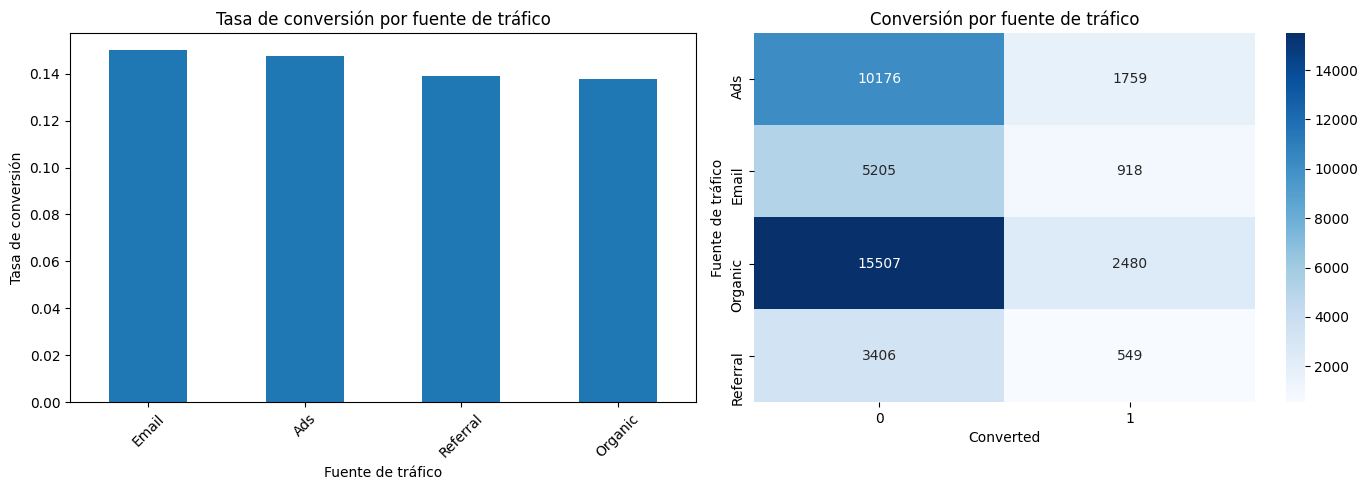

In [ ]:
# Crear figura con 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Tasa de conversión por canal

conversion_por_canal.plot(
    kind='bar',
    ax=axes[0]
)

axes[0].set_title("Tasa de conversión por fuente de tráfico")
axes[0].set_xlabel("Fuente de tráfico")
axes[0].set_ylabel("Tasa de conversión")
axes[0].tick_params(axis='x', rotation=45)


# Gráfico 2: Heatmap de contingencia

sns.heatmap(
    tabla_trafico,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=axes[1]
)

axes[1].set_title("Conversión por fuente de tráfico")
axes[1].set_xlabel("Converted")
axes[1].set_ylabel("Fuente de tráfico")

# Ajuste final
plt.tight_layout()
plt.show()

In [ ]:
print("\n=== DECISIÓN ===")

if p_value < alpha:
    print(f"→ Se RECHAZA la hipótesis nula H₀ (p = {p_value:.4f} < {alpha})")
    print("  Existe asociación estadísticamente significativa")
    print("  entre la fuente de tráfico y la conversión.")
else:
    print(f"→ NO se rechaza la hipótesis nula H₀ (p = {p_value:.4f} ≥ {alpha})")
    print("  No existe evidencia suficiente de asociación entre la fuente de tráfico y la conversión.")


=== DECISIÓN ===
→ Se RECHAZA la hipótesis nula H₀ (p = 0.0341 < 0.05)
  Existe asociación estadísticamente significativa
  entre la fuente de tráfico y la conversión.


### 📝 Conclusión e interpretación


**Decisión estadística:** Se rechaza la hipótesis nula.

**Interpretación estadística:**
Los resultados sugieren que la probabilidad de conversión no es completamente independiente de la fuente de tráfico.
Si bien la asociación es estadísticamente significativa, las tasas de conversión entre las distintas fuentes se concentran en un rango estrecho, aproximadamente entre 12% y 15%, lo que indica que las diferencias en desempeño relativo entre canales son moderadas.

El gráfico de tasas permite observar pequeñas variaciones en la eficiencia de conversión entre fuentes, mientras que el heatmap evidencia una distribución heterogénea del volumen de usuarios, lo que influye directamente en el número absoluto de conversiones observadas.

**Interpretación de negocio:**  
Desde una perspectiva de negocio, los resultados indican que las fuentes de tráfico no contribuyen de manera homogénea al total de conversiones.
Algunos canales concentran un mayor volumen de usuarios, lo que se traduce en un mayor número absoluto de conversiones, aun cuando sus tasas de conversión sean similares a las de otros canales.

Este hallazgo sugiere que la evaluación del desempeño de los canales debe considerar tanto la tasa de conversión como el volumen de tráfico, ya que analizar únicamente una de estas métricas podría conducir a conclusiones incompletas.

## 👤 Paso 5: Revisar la relación entre el tipo de usuario y la conversión

Se analiza si existe una **asociación estadísticamente significativa** entre el **tipo de usuario** (`user_type`) y la **conversión** (`converted`), entendiendo que un usuario recurrente puede haber visitado antes sin necesariamente convertirse en cliente en esta ocasión.

El objetivo es identificar qué perfiles muestran mayor probabilidad de conversión dentro del contexto analizado.

### Prueba Chi-cuadrado de independencia

**Hipótesis:**
- **Hipótesis nula (H₀):** El tipo de usuario y la conversión son independientes. El tipo de usuario NO influye en la probabilidad de conversión.
- **Hipótesis alternativa (H₁):** Existe una asociación significativa entre el tipo de usuario y la conversión. El tipo de usuario SÍ influye en la conversión.

In [ ]:
# Tabla de contingencia
tabla_usertype = pd.crosstab(df['user_type'], df['converted'])
tabla_usertype.columns = ['No Convertido', 'Convertido']

# Calcular tasa de conversión
tabla_usertype['Total'] = tabla_usertype.sum(axis=1)
tabla_usertype['Tasa Conv (%)'] = (
    tabla_usertype['Convertido'] / tabla_usertype['Total'] * 100
).round(2)

tabla_usertype = tabla_usertype.sort_values('Tasa Conv (%)', ascending=False)

print("=== Conversión por Tipo de Usuario ===")
print(tabla_usertype)

=== Conversión por Tipo de Usuario ===
            No Convertido  Convertido  Total  Tasa Conv (%)
user_type                                                  
Nuevo               22295        3738  26033          14.36
Recurrente          11999        1968  13967          14.09


In [ ]:
from scipy.stats import chi2_contingency
# Aplicar prueba

chi2, p_value, dof, expected = chi2_contingency(
    tabla_usertype[['No Convertido', 'Convertido']]
)

# Cramér's V
n = tabla_usertype[['No Convertido', 'Convertido']].values.sum()
cramers_v = np.sqrt(chi2 / (n * (min(tabla_usertype.shape[0]-1, 1))))

print("\n=== Prueba Chi-cuadrado ===")
print(f"Chi²        : {chi2:.4f}")
print(f"p-value     : {p_value:.4f}")
print(f"Cramér's V  : {cramers_v:.4f}")


=== Prueba Chi-cuadrado ===
Chi²        : 0.5135
p-value     : 0.4736
Cramér's V  : 0.0036


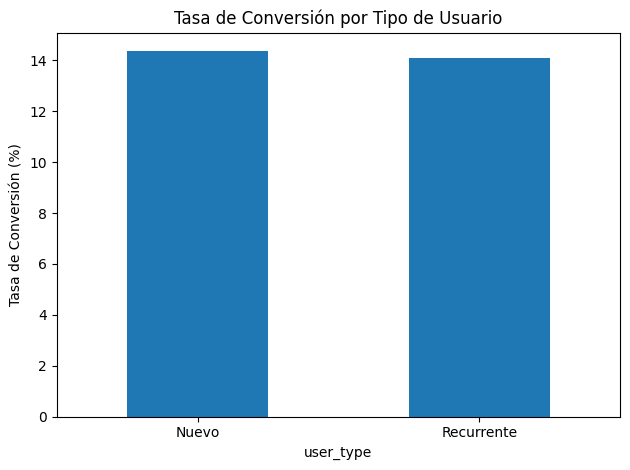

In [ ]:
# Visualización
tasas = tabla_usertype['Tasa Conv (%)']

plt.figure()
tasas.plot(kind='bar')
plt.title('Tasa de Conversión por Tipo de Usuario')
plt.ylabel('Tasa de Conversión (%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
mejor_perfil = tabla_usertype['Tasa Conv (%)'].idxmax()
menor_perfil = tabla_usertype['Tasa Conv (%)'].idxmin()

print("\n=== RESULTADOS CLAVE ===")
for perfil in tabla_usertype.index:
    tasa = tabla_usertype.loc[perfil, 'Tasa Conv (%)']
    total = tabla_usertype.loc[perfil, 'Total']
    print(f"• {perfil}: {tasa:.2f}% de conversión sobre {total:,} usuarios")

print("\n=== DECISIÓN ESTADÍSTICA ===")
if p_value < 0.05:
    print(f"→ Se RECHAZA la hipótesis nula H₀ (p = {p_value:.4f} < 0.05)")
    print("  Existe asociación estadísticamente significativa entre")
    print("  el tipo de usuario y la conversión.")
else:
    print(f"→ NO se rechaza la hipótesis nula H₀ (p = {p_value:.4f} ≥ 0.05)")
    print("  No se detecta asociación significativa entre")
    print("  el tipo de usuario y la conversión.")

print("\n=== INTERPRETACIÓN DE NEGOCIO ===")
print(f"• El tipo de usuario con mayor tasa de conversión es: {mejor_perfil}")
print(f"• El tipo de usuario con menor tasa de conversión es: {menor_perfil}")
print(
    "• Esto indica que el comportamiento de conversión varía según el perfil,\n"
    "  aunque la magnitud del efecto debe interpretarse junto a otras\n"
    "  variables del experimento."
)

print("\n=== MAGNITUD DEL EFECTO ===")
print(f"• Cramér's V = {cramers_v:.4f} → asociación ", end="")
if cramers_v < 0.1:
    print("despreciable")
elif cramers_v < 0.3:
    print("pequeña")
elif cramers_v < 0.5:
    print("moderada")
else:
    print("fuerte")



=== RESULTADOS CLAVE ===
• Nuevo: 14.36% de conversión sobre 26,033 usuarios
• Recurrente: 14.09% de conversión sobre 13,967 usuarios

=== DECISIÓN ESTADÍSTICA ===
→ NO se rechaza la hipótesis nula H₀ (p = 0.4736 ≥ 0.05)
  No se detecta asociación significativa entre
  el tipo de usuario y la conversión.

=== INTERPRETACIÓN DE NEGOCIO ===
• El tipo de usuario con mayor tasa de conversión es: Nuevo
• El tipo de usuario con menor tasa de conversión es: Recurrente
• Esto indica que el comportamiento de conversión varía según el perfil,
  aunque la magnitud del efecto debe interpretarse junto a otras
  variables del experimento.

=== MAGNITUD DEL EFECTO ===
• Cramér's V = 0.0036 → asociación despreciable


### 📝 Conclusión e interpretación

**Decisión estadística:** No se rechaza la hipótesis nula.

**Interpretación estadística:** Las diferencias observadas en las tasas de conversión entre usuarios nuevos y recurrentes son marginales y se encuentran dentro de un rango compatible con la variabilidad muestral. La magnitud del efecto estimada confirma que la relación entre ambas variables es prácticamente nula, por lo que el tipo de usuario no explica de manera relevante el comportamiento de conversión en este experimento.

**Interpretación de negocio:** En términos de negocio, este resultado sugiere que las diferencias observadas entre usuarios nuevos y recurrentes no generan un impacto relevante en la conversión. Por lo tanto, el tipo de usuario no emerge como un factor diferenciador clave en esta etapa del funnel, lo que indica que otras variables del experimento —como la versión de la landing page u otras dimensiones de segmentación— podrían tener mayor peso explicativo sobre el comportamiento de conversión.

## 📊 Paso 6: Visualizar los resultados de variables categóricas

Se explora visualmente la relación entre variables categóricas (`traffic_source` y `user_type`) y la conversión, mostrando para cada categoría:
- la cantidad absoluta de usuarios que convirtieron y no convirtieron,
- la proporción de usuarios que convirtieron y no convirtieron.

Esto permite analizar tanto el impacto en volumen como la efectividad relativa de cada categoría y reforzar los resultados obtenidos en las pruebas estadísticas.

### Relación entre la fuente de tráfico y la conversión

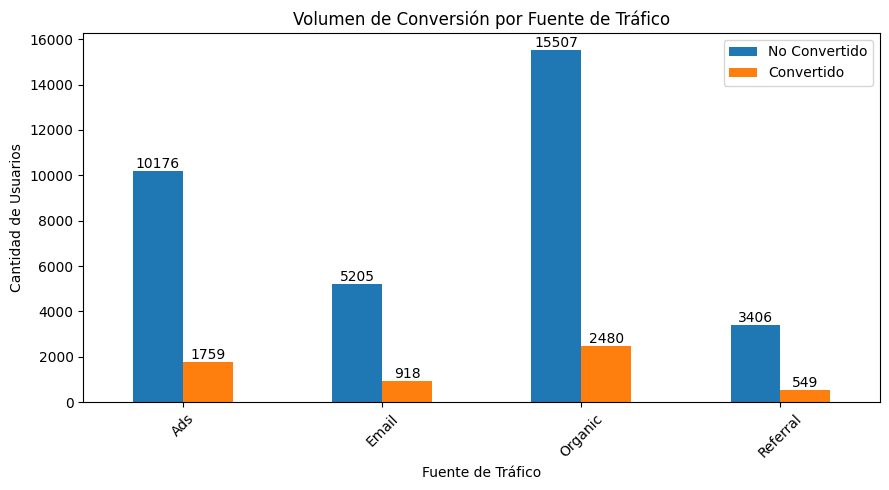

In [ ]:
# Tabla de conteos
tabla_traffic = pd.crosstab(df['traffic_source'], df['converted'])
tabla_traffic.columns = ['No Convertido', 'Convertido']

ax = tabla_traffic.plot(kind='bar', figsize=(9,5))

# Etiquetas de valor
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)

plt.title('Volumen de Conversión por Fuente de Tráfico')
plt.ylabel('Cantidad de Usuarios')
plt.xlabel('Fuente de Tráfico')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Fuente de Tráfico vs Conversión**

El gráfico presenta, para cada canal de tráfico, la cantidad total de usuarios que convirtieron y que no convirtieron. Esto permite identificar qué fuentes generan mayor volumen de usuarios y mayor número absoluto de conversiones.

El canal Organic concentra el mayor volumen de usuarios, seguido por Ads, mientras que Email y Referral presentan menor escala.
Esta diferencia en volumen explica que Organic lidere en número absoluto de conversiones, dado su mayor aporte de tráfico total.

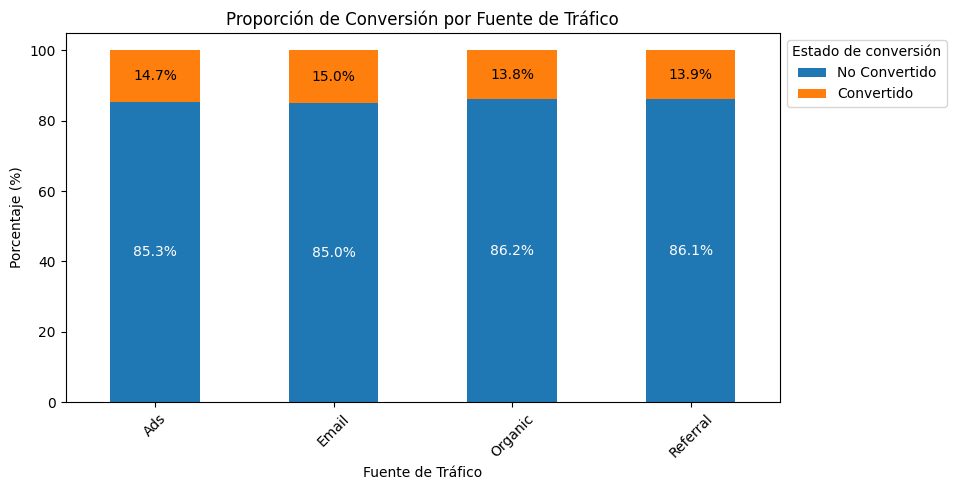

In [ ]:
tabla_traffic_pct = tabla_traffic.div(tabla_traffic.sum(axis=1), axis=0) * 100

ax = tabla_traffic_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5)
)

# Etiquetas porcentuales centradas
for i, row in enumerate(tabla_traffic_pct.values):
    acumulado = 0
    for val in row:
        ax.text(
            i,
            acumulado + val / 2,
            f'{val:.1f}%',
            ha='center',
            va='center',
            fontsize=10,
            color='white' if val > 15 else 'black'
        )
        acumulado += val

plt.title('Proporción de Conversión por Fuente de Tráfico')
plt.ylabel('Porcentaje (%)')
plt.xlabel('Fuente de Tráfico')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(
    title="Estado de conversión",
    loc= 'upper left',bbox_to_anchor=(1,1),
    frameon=True
)
plt.show()

**Proporción de conversión por fuente de tráfico**

El gráfico muestra la distribución porcentual de usuarios convertidos y no convertidos dentro de cada canal, permitiendo comparar la tasa de conversión relativa entre fuentes de tráfico.

Las tasas de conversión entre los cuatro canales son similares y se mantienen dentro de un rango estrecho. Aunque se observa una ligera variación entre ellos, las diferencias son marginales en términos prácticos.

Esta uniformidad en las tasas de conversión es consistente con el efecto práctico débil identificado previamente, donde la asociación entre canal y conversión resultó estadísticamente significativa pero con magnitud despreciable.

### Relación entre el tipo de usuario y la conversión

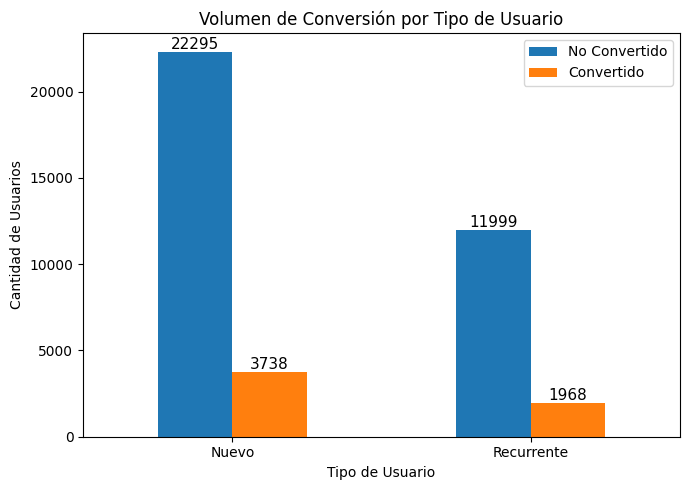

In [ ]:
tabla_user = pd.crosstab(df['user_type'], df['converted'])
tabla_user.columns = ['No Convertido', 'Convertido']

ax = tabla_user.plot(kind='bar', figsize=(7,5))

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11)

plt.title('Volumen de Conversión por Tipo de Usuario')
plt.ylabel('Cantidad de Usuarios')
plt.xlabel('Tipo de Usuario')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Tipo de Usuario vs Conversión**

El gráfico analiza el comportamiento de conversión según el perfil del usuario: **Nuevo** (primera visita) vs **Recurrente** (ha visitado antes).

Los usuarios Nuevos representan el 65.1% del tráfico total del experimento (26,033 vs 13,967 usuarios Recurrentes), concentrando así la mayor parte del volumen observado.

En términos absolutos, este mayor peso en el tráfico se traduce en un número superior de conversiones (3,738 vs 1,968). No obstante, las tasas de conversión son prácticamente equivalentes entre ambos perfiles
(14.36% para Nuevos vs 14.09% para Recurrentes), lo que indica niveles similares de eficiencia.

Este patrón visual refuerza el resultado estadístico previo (p = 0.4736), donde no se detectó una asociación significativa entre el tipo de usuario y la conversión.

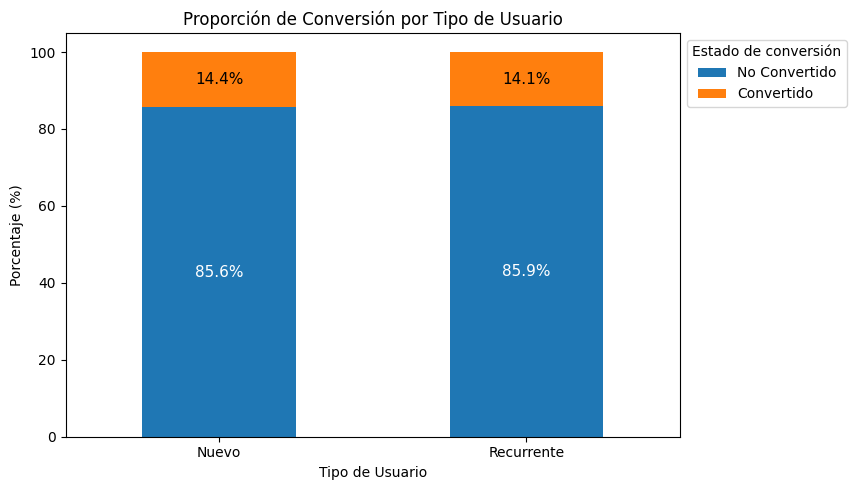

In [ ]:
tabla_user_pct = tabla_user.div(tabla_user.sum(axis=1), axis=0) * 100

ax = tabla_user_pct.plot(
    kind='bar',
    stacked=True,
    figsize=(7,5)
)

for i, row in enumerate(tabla_user_pct.values):
    acumulado = 0
    for val in row:
        ax.text(
            i,
            acumulado + val / 2,
            f'{val:.1f}%',
            ha='center',
            va='center',
            fontsize=11,
            color='white' if val > 15 else 'black'
        )
        acumulado += val

plt.title('Proporción de Conversión por Tipo de Usuario')
plt.ylabel('Porcentaje (%)')
plt.xlabel('Tipo de Usuario')
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend(
    title="Estado de conversión",
    loc= 'upper left',bbox_to_anchor=(1,1),
    frameon=True
)
plt.show()

**Proporción de Conversión por Tipo de Usuario**

El gráfico muestra la proporción (%) de usuarios convertidos y no convertidos dentro de cada tipo de usuario (Nuevo vs Recurrente).

Las tasas de conversión entre ambos perfiles son prácticamente idénticas, con una diferencia de apenas 0.3 puntos porcentuales, lo que indica un comportamiento muy similar en términos de probabilidad de conversión.

Este patrón visual es consistente con los resultados estadísticos del Paso 5:

χ² = 0.51 | p = 0.4736 → no se rechaza la hipótesis nula

Cramér’s V = 0.004 → asociación despreciable

En consecuencia, el tipo de usuario no emerge como un factor determinante para explicar la conversión dentro del contexto de este experimento.

## 🧩 Paso 7. Insight Ejecutivo para Stakeholders

Se traducen los hallazgos del análisis del experimento A/B en conclusiones accionables para el negocio, enfocadas en **versión de página, conversión, gasto promedio, canales de tráfico y tipo de usuario**.

**Preguntas a responder:**  
- ¿Qué página genera mayor conversión y gasto promedio?  
- ¿Qué canales de tráfico son más efectivos para generar conversiones?  
- ¿Existen diferencias significativas según el tipo de usuario?  
- ¿Qué recomendaciones se pueden tomar para optimizar la estrategia de marketing?


---

### 🌟 Insight Ejecutivo basado en el Experimento A/B

#### 🔍 **Comparación de página (A vs B)**  

**Gasto promedio por usuario que convirtió:**
- Observacion 1: La página B presenta un gasto promedio por usuario convertido un 12.5% superior a la página A (media: 68.75 vs 61.09; mediana: 62.57 vs 55.84), con una diferencia estadísticamente significativa (p < 0.001).
- Observacion 2: El análisis no paramétrico (Mann-Whitney U) confirma que en el 57.4% de los casos un usuario de la página B gasta más que uno de la página A, lo que evidencia una mejora consistente y no atribuible al azar.
- **Interpretación:** La página B incrementa de forma sistemática el ingreso por conversión, por lo que su implementación genera un impacto financiero directo y medible.

<br>


**Tasa de conversión:**
- Observacion 1: La tasa de conversión de la Página B supera a la Página A en 3.39 puntos porcentuales (15.96% vs 12.57%), manteniendo una distribución balanceada de usuarios entre ambas versiones del experimento.
- Observacion 2: La diferencia observada es estadísticamente significativa, de acuerdo con los resultados del Z-test y la prueba Chi-cuadrado (p < 0.001), lo que descarta que el efecto se deba a fluctuaciones aleatorias.
- **Interpretación:** La Página B presenta un desempeño claramente superior en términos de conversión. Este incremento equivale a aproximadamente 33 conversiones adicionales por cada 1.000 usuarios, manteniendo constante el volumen de tráfico.
La evidencia estadística respalda que la mejora observada es real y consistente, confirmando que el mejor rendimiento de la Página B no es producto del azar, sino del diseño y la experiencia optimizada.

---

#### 📊 **Segmentación por fuente de tráfico**
- Observacion: Las tasas de conversión por canal varían levemente entre 13.8% y 15.0%, siendo Email el canal con mayor eficiencia relativa y Organic el de mayor volumen de conversiones. Aunque existe asociación estadística entre canal y conversión (χ² p = 0.034), el tamaño del efecto es prácticamente nulo (Cramér’s V ≈ 0.004).

- **Interpretación:** El canal no es un diferenciador fuerte de conversión, pero sí explica el volumen; la estrategia debe equilibrar eficiencia (Email) y escala (Organic).

 ---

#### 📊 **Segmentación por tipo de usuario**
- Observacion: Las tasas de conversión entre usuarios nuevos (14.4%) y recurrentes (14.1%) son prácticamente equivalentes. No se detecta diferencia estadísticamente significativa (χ² p = 0.47), con un tamaño de efecto despreciable.

- **Interpretación:** El tipo de usuario no influye de manera relevante en la probabilidad de conversión; el mayor impacto proviene del alto volumen de usuarios nuevos.
  
---

Las visualizaciones usadas respaldan los resultados estadísticos de pasos anteriores.

---

#### 💡 **Recomendaciones de negocio:**

**1. Implementar la página B como versión definitiva**: Considerando los resultados del experimento A/B y la evidencia estadística obtenida, se sugiere implementar la página B como versión final de la landing page.
Esta versión presenta una tasa de conversión superior y un mayor gasto promedio por usuario convertido, con diferencias estadísticamente significativas y consistentes entre múltiples pruebas.
La mejora observada no puede atribuirse al azar y representa una oportunidad clara de incrementar el rendimiento global del negocio.

**2. Priorizar la optimización de canales según volumen y eficiencia**: El análisis por fuente de tráfico muestra que las tasas de conversión son similares entre canales, por lo que la estrategia debe diferenciarse según el rol de cada uno:
> - *Organic* debe mantenerse como canal estratégico por su alto volumen de tráfico y conversiones absolutas.
> - *Email* destaca por su mayor eficiencia relativa, lo que sugiere potencial de crecimiento si se amplía su alcance.
> - *Ads* presenta un desempeño equilibrado entre volumen y conversión, siendo un canal estable a optimizar en conjunto con la página B.
> - *Referral* muestra menor impacto tanto en volumen como en eficiencia, por lo que su rol debe evaluarse con cautela.

**3. Evitar segmentaciones basadas exclusivamente en tipo de usuario**: No se detectaron diferencias estadísticamente significativas en la probabilidad de conversión entre usuarios Nuevos y Recurrentes.
Por lo tanto, segmentar la estrategia de conversión únicamente por tipo de usuario no emerge como una palanca prioritaria dentro del contexto de este experimento.

Sin embargo, dado que los usuarios nuevos concentran la mayor parte del tráfico, mejoras generales en la experiencia de primera visita pueden generar impacto a nivel agregado.

**4. Enfocar optimizaciones futuras en la experiencia y el funnel**: Los resultados sugieren que las principales mejoras provienen del diseño y contenido de la página, más que de características del usuario o del canal.
Futuros experimentos deberían explorar elementos de la landing page (mensaje, estructura, claridad del valor, confianza) y su interacción con los distintos canales de adquisición.

---
En conjunto, el experimento demuestra que la optimización de la landing page es el factor más determinante del desempeño, mientras que las diferencias por canal y tipo de usuario tienen un efecto secundario o contextual. La implementación de la página B, acompañada de una gestión estratégica de los canales según volumen y eficiencia, representa el camino más consistente para mejorar resultados.